In [1]:
##Do not touch unless adding in additional packages
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import SymLogNorm
from IPython.display import HTML, display
import pandas as pd

from landlab import RasterModelGrid
from landlab.components import (
    PriorityFloodFlowRouter, SpaceLargeScaleEroder, SpatialPrecipitationDistribution,
    LateralEroder, Space, DepressionFinderAndRouter, FlowAccumulator, OverlandFlow
)
from landlab.plot import imshowhs_grid
import os

In [2]:
def initialize_grid():
    mg = RasterModelGrid((100, 50), xy_spacing=10.0)  # Grid spacing now meters

    ##Do not edit
    z = mg.add_zeros("topographic__elevation", at="node")
    x = mg.node_x
    y = mg.node_y
    grid_width = x.max()
    grid_height = y.max()
    center_x = grid_width / 2

    # Elevation shaping
    slope_profile = 20.0 * (y / grid_height) ** 2
    valley = -3.0003 * np.exp(-((x - center_x) ** 2) / (2 * (200 ** 2)))

    growth = 2.0 * (
        np.exp(-(((x - 100) ** 2 + (y - 100) ** 2) / (2 * 100 ** 2))) +
        np.exp(-(((x - (grid_width - 100)) ** 2 + (y - 100) ** 2) / (2 * 100 ** 2))) +
        np.exp(-(((x - 10) ** 2 + (y - grid_height) ** 2) / (2 * 100 ** 2))) +
        np.exp(-(((x - (grid_width - 10)) ** 2 + (y - grid_height) ** 2) / (2 * 100 ** 2)))
    )

    z += slope_profile + valley + growth
    z += np.random.normal(scale=0.06, size=z.size)  # Z: Elevation

    s = mg.add_zeros("soil__depth", at="node", dtype=float)
    s += 0.3
    z += s

    ##Do not touch unless you want to adjust your watershed outlet
    mg.set_closed_boundaries_at_grid_edges(True, True, True, True)
    bottom_nodes = mg.nodes_at_bottom_edge
    bottom_center = bottom_nodes[len(bottom_nodes) // 2]
    mg.status_at_node[bottom_center] = mg.BC_NODE_IS_FIXED_VALUE

    return mg

In [3]:
def run_model_with_animation(mg, rain, label, n_steps, dt, uplift_rate=0.00002, every_n=50):##. mm = 1mm/yr
    mg.add_field("water__unit_flux_in", rain, at="node", clobber=True)

    fr = PriorityFloodFlowRouter(mg, flow_metric="D8", update_flow_depressions=True)
    ha = SpaceLargeScaleEroder(mg, K_sed=5e-6, K_br=1e-6, phi=0.4, H_star=1.0)

    artists = []
    fig, ax = plt.subplots(figsize=(6, 6))

    # rainfall tally tracker
    rainfall_records = []

    for step in tqdm(range(n_steps), desc=f"Running model: {label}"):
        fr.run_one_step()
        ha.run_one_step(dt)

        # ensure bedrock field exists before trying to update
        if "bedrock__elevation" in mg.at_node:
            mg.at_node["bedrock__elevation"][mg.core_nodes] += uplift_rate * dt
        else:
            # create bedrock field based on topographic__elevation - soil__depth if necessary
            mg.add_field("bedrock__elevation", mg.at_node["topographic__elevation"] - mg.at_node["soil__depth"], at="node", clobber=True)
            mg.at_node["bedrock__elevation"][mg.core_nodes] += uplift_rate * dt

        mg.at_node["topographic__elevation"][:] = (
            mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
        )

        # Record rainfall total every step (scaled to meters/year * dt years)
        rain_total = np.mean(rain) * dt   # avg rainfall over domain * years
        rainfall_records.append({
            "Step": step,
            "Model Time (years)": step * dt,
            "Total Rain (m)": rain_total
        })

        if step % every_n == 0:
            elev_raster = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
            im = ax.imshow(elev_raster, cmap="terrain", origin="lower",
                           extent=[0, mg.extent[1]/1000, 0, mg.extent[0]/1000],  # km scale
                           animated=True, aspect="auto")
            title = ax.text(2, 5, f"Step {step}", color='white', fontsize=10, animated=True)
            artists.append([im, title])

    ani = animation.ArtistAnimation(fig, artists, interval=200, blit=True)
    plt.close(fig)

    # convert rainfall tally to DataFrame and print as table (every step = 2000 yrs if dt=2000)
    df = pd.DataFrame(rainfall_records)
    print(f"\nRainfall Tally for {label} (per {dt} years step):")
    display(df.head(15))  # show first few rows

    return mg, ani

In [4]:

# ========== Flow Routing and Lateral Erosion ==========
def run_flow_and_lateral_erosion(mg):
    from landlab.components import SpaceLargeScaleEroder

    #  Step 1: Flow routing 
    flow_metric = "D8"
    flow_acc_PF = PriorityFloodFlowRouter(
        mg,
        surface="topographic__elevation",
        flow_metric=flow_metric,
        suppress_out=True,
        depression_handler="fill",
        accumulate_flow=True,
        separate_hill_flow=True,
        accumulate_flow_hill=True,
    )
    flow_acc_PF.run_one_step()

    #  Step 2: Lateral erosion setup 
    mg.add_zeros("volume__lateral_erosion", at="node", clobber=True)
    lateral = LateralEroder(mg, latero_mech="UC", Kv=0.001, Kl_ratio=1.5) 
    #Kv  Bedrock erodibility in vertical direction, 1/years
    #Kl_ratio  Ratio of lateral to vertical bedrock erodibility

    #  Step 3: SPACE (sediment transport & flux) setup 
    space = SpaceLargeScaleEroder(
        mg,
        K_sed=5e-6,
        K_br=1e-6,
        F_f=0.4,
        phi=0.4,
        H_star=1.0,
        v_s=0.001,
        m_sp=0.5,
        n_sp=1.0,
    )

    dt = 100
    uplift_rate = 0.001

    # --- Step 4: Run both erosion and sediment transport ---
    for _ in range(10):
        flow_acc_PF.run_one_step()
        lateral.run_one_step(dt)
        space.run_one_step(dt=dt)
        if "bedrock__elevation" in mg.at_node:
            mg.at_node["bedrock__elevation"][mg.core_nodes] += uplift_rate * dt
        else:
            mg.add_field("bedrock__elevation", mg.at_node["topographic__elevation"] - mg.at_node["soil__depth"], at="node", clobber=True)
            mg.at_node["bedrock__elevation"][mg.core_nodes] += uplift_rate * dt
        mg.at_node["topographic__elevation"][:] = (
            mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
        )

    # Step 5: Compute sediment flux (based on erosion and deposition)
    # Check if these fields exist; if not, compute proxies
    if "sediment__erosion_rate" in mg.at_node and "sediment__deposition_rate" in mg.at_node:
        sed_flux = mg.at_node["sediment__erosion_rate"] - mg.at_node["sediment__deposition_rate"]
        label = "Net Sediment Flux (Erosion - Deposition)"
    else:
        # fallback proxy using drainage area and slope
        da = mg.at_node["drainage_area"]
        slope = mg.calc_grad_at_link("topographic__elevation")
        # map_mean_of_links_to_node alias
        try:
            slope_at_node = mg.map_mean_of_links_to_node(slope)
        except Exception:
            from landlab.grid.mappers import map_mean_of_links_to_node
            slope_at_node = map_mean_of_links_to_node(mg, slope)
        sed_flux = da * slope_at_node
        label = "Estimated Sediment Flux (Drainage × Slope)"

    mg.add_field("sediment__flux", sed_flux, at="node", clobber=True)

    # --- Step 6: Plot results ---

    #  Lateral erosion
    plt.figure()
    mg.imshow(
        "volume__lateral_erosion",
        plot_name="Volume of Lateral Erosion",
        var_name="Volume ($m^3$)",
        cmap="viridis",
        norm=SymLogNorm(
            linthresh=1e-2,
            vmin=0.01,
            vmax=np.max(mg.at_node["volume__lateral_erosion"]),
        ),
    )
    plt.title("Volume of Lateral Erosion (Base Run)")
    plt.colorbar(label="Volume ($m^3$)")
    plt.show()

    # Lateral erosion for new Section A
    plt.figure()
    mg.imshow(
        "volume__lateral_erosion",
        plot_name="Volume of Lateral Erosion — Section A",
        var_name="Volume ($m^3$)",
        cmap="plasma",
        norm=SymLogNorm(
            linthresh=1e-2,
            vmin=0.01,
            vmax=np.max(mg.at_node["volume__lateral_erosion"]),
        ),
    )
    plt.title("Volume of Lateral Erosion — Section A")
    plt.colorbar(label="Volume ($m^3$)")
 
    plt.title(label)
    plt.show()

    return mg

In [5]:
# 100 × 1-year series starting from a base elevation
def run_100yr_annual_series(base_elevation, label, annual_rain_m, infiltration_fraction=0.0, n_years=100):
    
    print(f"\nRunning {label}: {annual_rain_m} m/yr rainfall, infiltration {infiltration_fraction*100:.1f}% for {n_years} years")

    # create fresh grid and set topography to base
    mg_s = initialize_grid()
    # ensure base_elevation matches grid size
    if base_elevation.size == mg_s.number_of_nodes:
        mg_s.at_node["topographic__elevation"][:] = base_elevation.copy()
    else:
        # fallback: copy as much as possible
        min_len = min(base_elevation.size, mg_s.number_of_nodes)
        mg_s.at_node["topographic__elevation"][:] = base_elevation[:min_len].copy()
        print("Warning: base_elevation size didn't match grid nodes; truncated/filled.")

    # create bedrock if not present
    if "bedrock__elevation" not in mg_s.at_node:
        mg_s.add_field("bedrock__elevation", mg_s.at_node["topographic__elevation"] - mg_s.at_node["soil__depth"], at="node", clobber=True)

    # effective rainfall after infiltration
    effective_rain = annual_rain_m * (1.0 - infiltration_fraction)
    rain_array = np.full(mg_s.number_of_nodes, effective_rain)

    # set water input field
    mg_s.add_field("water__unit_flux_in", rain_array, at="node", clobber=True)

    # components
    fr = PriorityFloodFlowRouter(mg_s, flow_metric="D8", update_flow_depressions=True)
    ha = SpaceLargeScaleEroder(mg_s, K_sed=5e-6, K_br=1e-6, phi=0.4, H_star=1.0)

    uplift_rate = 0.00002  # keep consistent with earlier usage
    dt = 1  # 1 year per step

    # run the n_years loop (no animation)
    for yr in tqdm(range(n_years), desc=label):
        fr.run_one_step()
        ha.run_one_step(dt)
        mg_s.at_node["bedrock__elevation"][mg_s.core_nodes] += uplift_rate * dt
        mg_s.at_node["topographic__elevation"][:] = mg_s.at_node["bedrock__elevation"] + mg_s.at_node["soil__depth"]

    # plot final elevation
    plt.figure(figsize=(6, 5))
    elev_raster = mg_s.node_vector_to_raster(mg_s.at_node["topographic__elevation"])
    im = plt.imshow(elev_raster, cmap="terrain", origin="lower",
                    extent=[0, mg_s.extent[1]/1000, 0, mg_s.extent[0]/1000], aspect="auto")
    plt.title(f"{label} - Elevation after {n_years} years ({annual_rain_m} m/yr, infil {infiltration_fraction*100:.1f}%)")
    plt.xlabel("Distance (km)")
    plt.ylabel("Distance (km)")
    plt.colorbar(im, label="Elevation (m)")
    plt.show()

    return mg_s

In [6]:
def main():
    # 1. Initial grid
    mg = initialize_grid()

    # Rainfall in meters per year
    uniform_rain = np.full(mg.number_of_nodes, 1.0)  # 1 m/yr everywhere

    # #Plot uniform rainfall
    # fig, ax = plt.subplots(figsize=(6, 5))
    # im = ax.imshow(uniform_rain.reshape(mg.shape), cmap="Blues", origin="lower",
    #                extent=[0, mg.extent[1]/1000, 0, mg.extent[0]/1000], aspect="auto")
    # ax.set_title("Uniform Rainfall Distribution (m/yr)")
    # ax.set_xlabel("Distance (km)")
    # ax.set_ylabel("Distance (km)")
    # plt.colorbar(im, ax=ax, label="Rainfall (m/yr)")
    # plt.show()

    # 2. Uniform rainfall phase with animation
    mg, ani1 = run_model_with_animation(
        mg, uniform_rain, "Uniform Rainfall Phase", n_steps=1000, dt=2000 # 2 MA
    )

    # 3. Save elevation
    elevation_after_uniform = mg.at_node["topographic__elevation"].copy()

    # 4. Topographic rainfall phase
    x = mg.node_x
    y = mg.node_y
    gradient_rain = 50.0 * (y / y.max())  # 0 at bottom, 50 at top

    # #  Plot gradient rainfall distribution
    # fig, ax = plt.subplots(figsize=(6, 5))
    # im = ax.imshow(gradient_rain.reshape(mg.shape), cmap="Blues", origin="lower",
    #                extent=[0, mg.extent[1]/1000, 0, mg.extent[0]/1000], aspect="auto")
    # ax.set_title("Gradient Rainfall Distribution (m/yr)")
    # ax.set_xlabel("Distance (km)")
    # ax.set_ylabel("Distance (km)")
    # plt.colorbar(im, ax=ax, label="Rainfall (m/yr)")
    # plt.show()

    # 5. Run model with gradient rainfall
    mg, ani2 = run_model_with_animation(
        mg, gradient_rain, "Concave Rainfall Phase", n_steps=100, dt=50
    )

    # 6. Save elevation
    elevation_after_topo = mg.at_node["topographic__elevation"].copy()

    # 7. Plot difference
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    im1 = axs[0].imshow(elevation_after_uniform.reshape(mg.shape), cmap="terrain", origin="lower",
                        extent=[0, mg.extent[1]/1000, 0, mg.extent[0]/1000])
    axs[0].set_title("Elevation After Uniform Rain/Steady State - 2 MA")
    axs[0].set_xlabel("Distance (km)")
    axs[0].set_ylabel("Distance (km)")
    plt.colorbar(im1, ax=axs[0], label="Elevation (m)")

    im2 = axs[1].imshow(elevation_after_topo.reshape(mg.shape), cmap="terrain", origin="lower",
                        extent=[0, mg.extent[1]/1000, 0, mg.extent[0]/1000])
    axs[1].set_title("Elevation After Concave Rain - 2.4 MA")
    axs[1].set_xlabel("Distance (km)")
    plt.colorbar(im2, ax=axs[1], label="Elevation (m)")

    diff = elevation_after_uniform - elevation_after_topo
    im3 = axs[2].imshow(diff.reshape(mg.shape), cmap="coolwarm", origin="lower",
                        extent=[0, mg.extent[1]/1000, 0, mg.extent[0]/1000])
    axs[2].set_title("Incision Difference (Steady State - Concave Rainfall)")
    axs[2].set_xlabel("Distance (km)")
    plt.colorbar(im3, ax=axs[2], label="Elevation Difference (m)")

    plt.tight_layout()
    plt.show()

    # 8. Show animations
    print("Animation: Uniform Rainfall Phase - 2 MA")
    display(HTML(ani1.to_jshtml()))
    print("Animation: Concave Rainfall Phase 2.04 MA")
    display(HTML(ani2.to_jshtml()))

    # 9. Flow + lateral erosion analysis
    print("Running flow accumulation and lateral erosion analysis...")
    run_flow_and_lateral_erosion(mg)

    # ========== SECTION A: 100 × 1-year runs with 1.20 m/yr rainfall, infiltration unchanged ==========
    # Keep infiltration the same (assume unchanged i.e., 0% infiltration applied here)
    mg_A = run_100yr_annual_series(
        elevation_after_uniform,
        label="Section A: 1.20 m/yr (infiltration unchanged)",
        annual_rain_m=1.20,
        infiltration_fraction=0.0,
        n_years=100
    )

    # ========== SECTION B: 100 × 1-year runs with 1.00 m/yr rainfall, infiltration = 20% ==========
    mg_B = run_100yr_annual_series(
        elevation_after_uniform,
        label="Section B: 1.00 m/yr (infiltration 20%)",
        annual_rain_m=1.00,
        infiltration_fraction=0.20,
        n_years=100
    )

    # ========== SECTION C: 100 × 1-year runs with 1.20 m/yr rainfall, infiltration = 20% ==========
    mg_C = run_100yr_annual_series(
        elevation_after_uniform,
        label="Section C: 1.20 m/yr (infiltration 20%)",
        annual_rain_m=1.20,
        infiltration_fraction=0.20,
        n_years=100
    )
    return mg_A

/Users/tiga7385/anaconda3/envs/aspect_code/lib/python3.13/site-packages/richdem/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Running model: Uniform Rainfall Phase: 100%|███████| 1000/1000 [00:55<00:00, 18.01it/s]



Rainfall Tally for Uniform Rainfall Phase (per 2000 years step):


,Step,Model Time (years),Total Rain (m)
0,0,0,2000.0
1,1,2000,2000.0
2,2,4000,2000.0
3,3,6000,2000.0
4,4,8000,2000.0
5,5,10000,2000.0
6,6,12000,2000.0
7,7,14000,2000.0
8,8,16000,2000.0
9,9,18000,2000.0


Running model: Concave Rainfall Phase: 100%|█████████| 100/100 [00:05<00:00, 17.88it/s]


Rainfall Tally for Concave Rainfall Phase (per 50 years step):


,Step,Model Time (years),Total Rain (m)
0,0,0,1250.0
1,1,50,1250.0
2,2,100,1250.0
3,3,150,1250.0
4,4,200,1250.0
5,5,250,1250.0
6,6,300,1250.0
7,7,350,1250.0
8,8,400,1250.0
9,9,450,1250.0


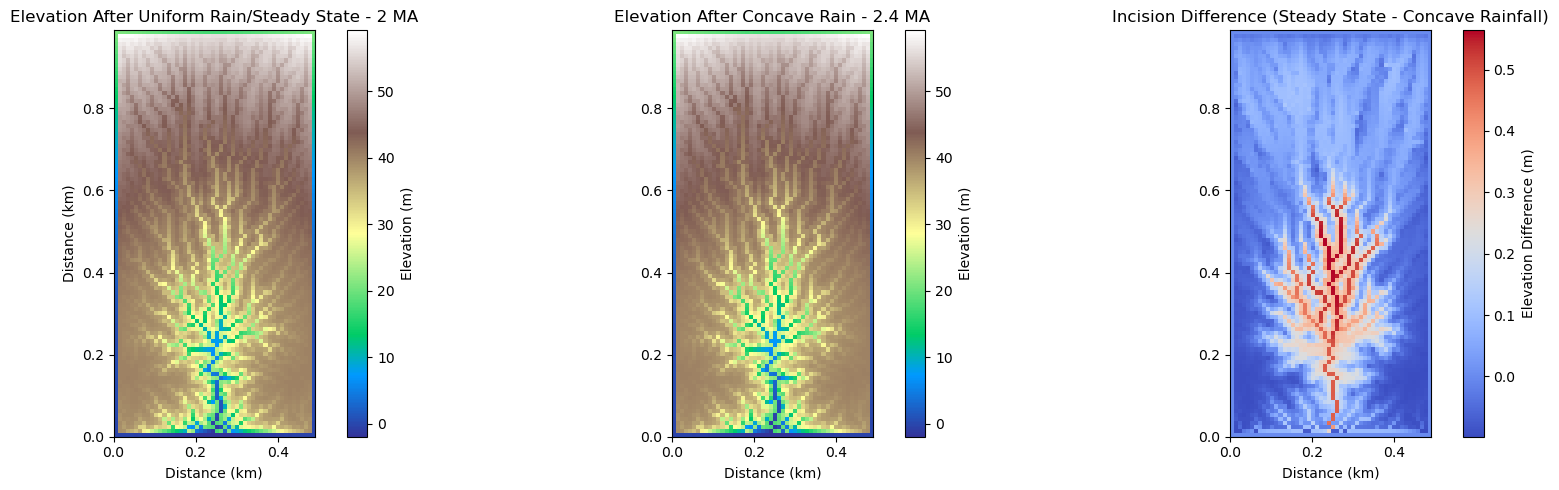

Animation: Uniform Rainfall Phase - 2 MA


Animation: Concave Rainfall Phase 2.04 MA


Running flow accumulation and lateral erosion analysis...


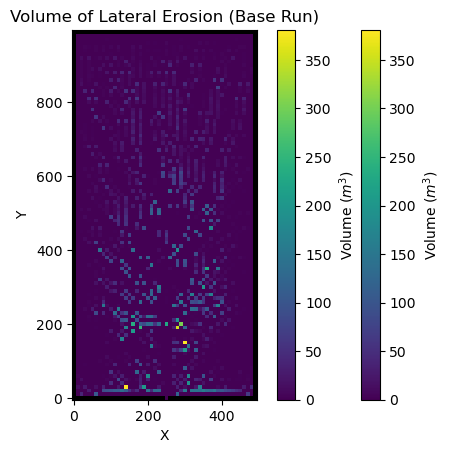

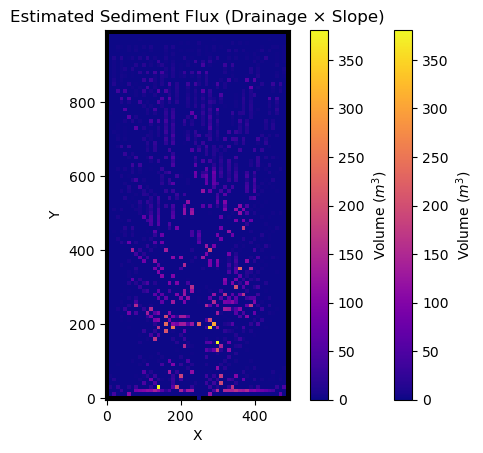


Running Section A: 1.20 m/yr (infiltration unchanged): 1.2 m/yr rainfall, infiltration 0.0% for 100 years


Section A: 1.20 m/yr (infiltration unchanged): 100%|█| 100/100 [00:05<00:00, 17.97it/s]


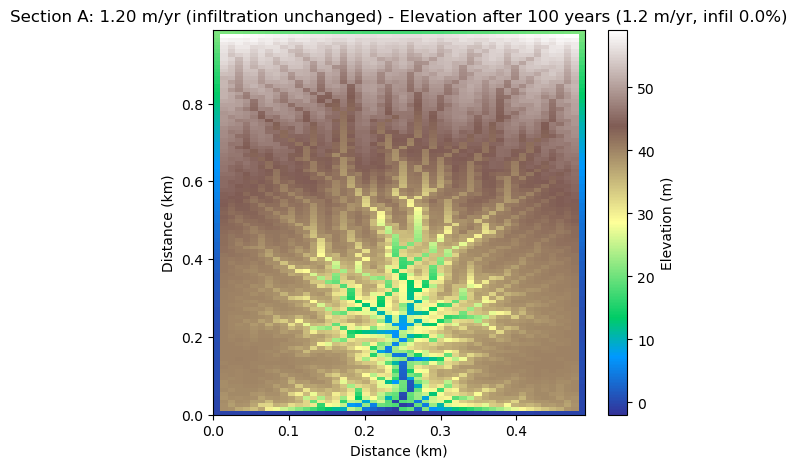


Running Section B: 1.00 m/yr (infiltration 20%): 1.0 m/yr rainfall, infiltration 20.0% for 100 years


Section B: 1.00 m/yr (infiltration 20%): 100%|███████| 100/100 [00:05<00:00, 17.69it/s]


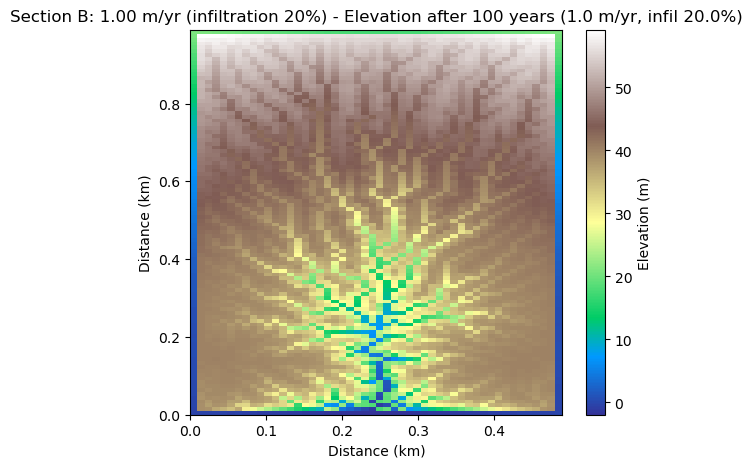


Running Section C: 1.20 m/yr (infiltration 20%): 1.2 m/yr rainfall, infiltration 20.0% for 100 years


Section C: 1.20 m/yr (infiltration 20%): 100%|███████| 100/100 [00:05<00:00, 17.71it/s]


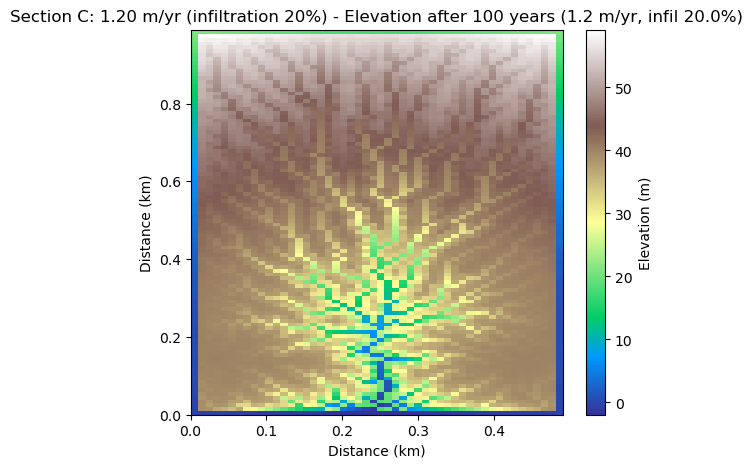

In [7]:
##Do not touch
# if __name__ == "__main__":
mg = main()  # store the main() output as mg

In [8]:
from landlab.components import OverlandFlow, FlowAccumulator
from landlab import RasterModelGrid, imshow_grid, imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.drainage_plot import drainage_plot
from landlab.utils import get_watershed_mask

In [9]:
# calculate the flow accumulation
# I would like the mg it routes to be the output of mg_A
# mg = mg_A()  remove this line
fa=FlowAccumulator( mg, method='Steepest', 
                    flow_director='FlowDirectorSteepest', 
                    depression_finder='LakeMapperBarnes',
                    redirect_flow_steepest_descent=True,
                    reaccumulate_flow=True)
fa.run_one_step()  



Text(0, 0.5, 'north-south distance (m)')

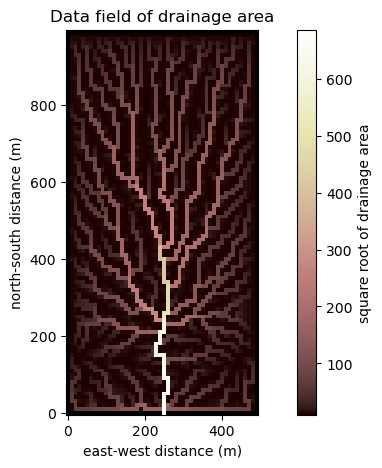

In [10]:
# plot the flow accumulation result
plt.figure(figsize=(10,5))
ax = plt.gca()
# ax.invert_yaxis()
imshow_grid(
    mg,
    np.sqrt(mg.at_node["drainage_area"]),
    plot_name="Data field of drainage area",
    var_name="square root of drainage area",
)
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')


In [11]:
# set up channel profiler 
profiler = ChannelProfiler(mg,number_of_watersheds=1)
profiler.run_one_step()

In [12]:
# get watershed mask
outlet = profiler.nodes[0][0]
watershed_mask = get_watershed_mask(mg, outlet)

In [13]:
# set watershed boundary
mg.at_node["topographic__elevation"][~watershed_mask] = -9999.0
mg.status_at_node[~watershed_mask] = mg.BC_NODE_IS_CLOSED
mg.status_at_node[outlet] = mg.BC_NODE_IS_FIXED_VALUE

Text(0, 0.5, 'north-south distance (m)')

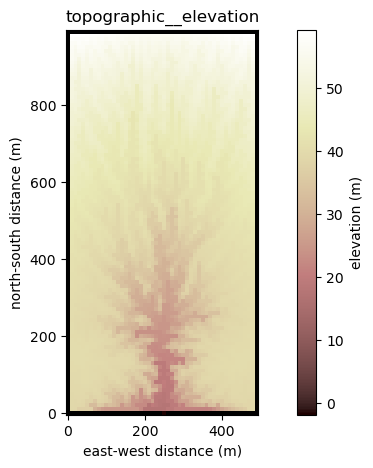

In [14]:
# plot the watershed 
plt.figure(figsize=(10,5))
ax = plt.gca()
# ax.invert_yaxis()
imshow_grid_at_node(mg, "topographic__elevation", 
                    plot_name='Topographic elevation of the watershed',
                    colorbar_label="elevation (m)")

ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')

In [15]:
# outlet id for watershed
print(outlet)

25


Running storm: 43205.61676822201it [00:14, 3086.00it/s]                                


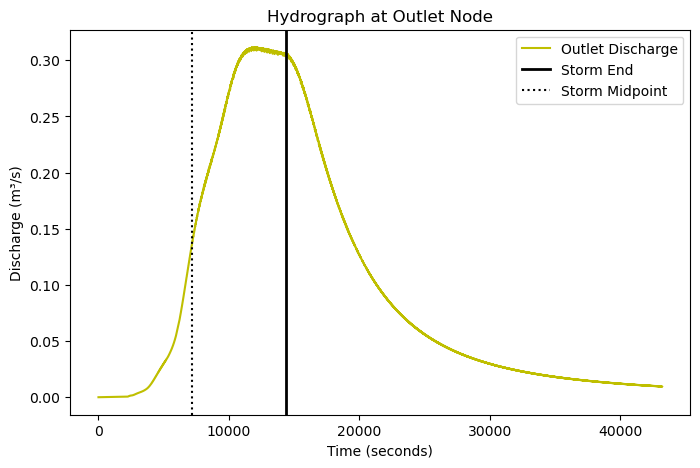

In [16]:
# ==================== SECTION D: Storm Runoff Hydrograph ====================

from landlab.components import OverlandFlow, FlowAccumulator

# Use mg from concave rainfall phase
#storm_mg = mg.()
#storm_mg.at_node["topographic__elevation"] = elevation_after_topo.copy()

# Set watershed boundaries
# storm_mg.set_watershed_boundary_condition(storm_mg.at_node["topographic__elevation"])

# Initialize OverlandFlow fields
#mg.add_zeros("surface_water__depth", at="node")
mg.add_zeros("surface_water__depth", at="node", clobber=True)


# Flow routing to compute drainage area
fa = FlowAccumulator(mg)
fa.run_one_step()

# Select outlet node (lowest boundary node)
#outlet_node_to_sample = np.argmin(storm_mg.at_node["topographic__elevation"][storm_mg.boundary_nodes])

# Initialize OverlandFlow component
of = OverlandFlow(mg, mannings_n=0.03, steep_slopes=True)
mg.at_node["surface_water__depth"].fill(
    1e-6
) # small initial water film

# Storm parameters
storm_duration = 14400.0  # 4 hours in seconds
starting_precip_mmhr = 2.5
starting_precip_ms = starting_precip_mmhr / 1000 / 3600  # convert mm/hr to m/s
model_run_time = 43200.0  # 12 hours total

# Lists to save discharge data
discharge_at_outlet = []
hydrograph_time = []

elapsed_time = 0.0
with tqdm(total=model_run_time, desc="Running storm") as pbar:
    while elapsed_time < model_run_time:
        # Adaptive timestep
        of.dt = of.calc_time_step()
        
        # Rainfall intensity
        if elapsed_time < storm_duration:
            of.rainfall_intensity = starting_precip_ms
        else:
            of.rainfall_intensity = 0.0
        
        # Advance overland flow
        of.run_one_step()
    ##change here for the dischargemapper at the outlet node  
        # Save discharge at outlet
        # q = storm_mg.at_link["surface_water__discharge"]
        # outlet_links = storm_mg.links_at_node[outlet_node_to_sample]
        # # sum positive discharge leaving the node
        # #discharge_at_outlet.append(np.sum(np.abs(q[outlet_links])) * storm_mg.dx)
        # hydrograph_time.append(elapsed_time)
# Discharge
        # get discharge result
        discharge = of.discharge_mapper(
            mg.at_link["surface_water__discharge"], convert_to_volume=True
        )
# store only the outlet node discharge
        discharge_at_outlet.append(discharge[outlet])
        hydrograph_time.append(elapsed_time)

        
        elapsed_time += of.dt
        pbar.update(of.dt)

# # Compute theoretical equilibrium discharge at outlet
# outlet_eq_q = starting_precip_ms * mg.at_node["drainage_area"][outlet_node_to_sample]

# Plot hydrograph
plt.figure(figsize=(8,5))
plt.plot(hydrograph_time, discharge_at_outlet, "y-", label="Outlet Discharge")
# plt.axhline(outlet_eq_q, color="y", linestyle="--", label="Outlet Equilibrium Q")
plt.axvline(storm_duration, color="k", linestyle="-", linewidth=2, label="Storm End")
plt.axvline(storm_duration / 2, color="k", linestyle=":", label="Storm Midpoint")
# plt.scatter(
#     # storm_mg.node_x[outlet_node_to_sample],
#     # storm_mg.node_y[outlet_node_to_sample],
#     color="yellow",
#     s=100,
#     label="Outlet Node"
# )
plt.xlabel("Time (seconds)")
plt.ylabel("Discharge (m³/s)")
plt.title("Hydrograph at Outlet Node")
plt.legend(loc="upper right")
plt.show()
